## Implementation of CNN on MNIST dataset using pytorch library

In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

c:\Program Files\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self, input_shape, classes=10):
        super(SimpleCNN, self).__init__()
        self.in_channels = input_shape[1] // 4 * input_shape[2] // 4 * 64
        self.conv1 = nn.Conv2d(input_shape[0], 32, 3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(num_features=64)
        self.fc1 =nn.Linear(self.in_channels, 128)
        self.fc2 = nn.Linear(128, classes)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(self.norm1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool(self.norm2(x))
        x = x.view(-1, self.in_channels)
        x = F.relu(self.fc1(x))
        out = F.softmax(self.fc2(x), dim=1)
        return out

In [3]:
trans = transforms.Compose([
        transforms.ToTensor()
    ]) 
train_dataset = datasets.CIFAR10('data', train=True, transform=trans, download=True)
test_dataset = datasets.CIFAR10('data', train=False, transform=trans, download=True)
print(train_dataset[0][0].shape)

100%|██████████| 170498071/170498071 [03:54<00:00, 727016.78it/s] 


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified
torch.Size([3, 32, 32])


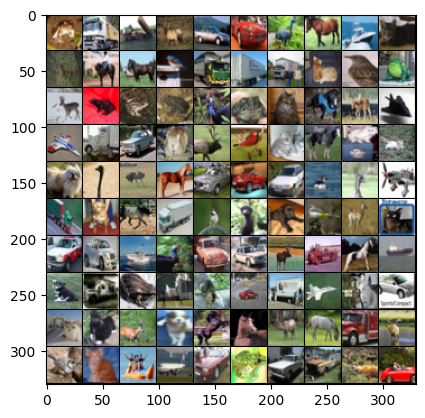

In [4]:
def display_tensor_image(dataset):
    im_shape = (3, 32, 32)
    num = 10
    im_display = np.ones((im_shape[1]*num + num, im_shape[2]*num + num, im_shape[0]), dtype=np.float32)
    for i in range(num*num):
        im = dataset[i][0].numpy().copy()
        im = im * 255.0
        im = np.transpose(im, (1, 2, 0))
        col = i % num
        row = i // num
        im_display[row*im_shape[1] + row:row*im_shape[1] + im_shape[1] + row, col*im_shape[2] + col:col*im_shape[2]+im_shape[2] + col] = im
    im_display = im_display.astype(np.uint8)
    plt.imshow(im_display)
display_tensor_image(train_dataset)

In [5]:
batch_size = 512
lr = 1e-4
epochs = 5


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
model = SimpleCNN(input_shape=train_dataset[0][0].shape, classes=10)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

In [9]:
use_gpu = torch.cuda.is_available()
hist = []
if use_gpu:
    model = model.cuda()
print("[INFO] Start training...")
for e in range(epochs):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader):
        if use_gpu:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    hist.append(total_loss)
    print(f"Epoch: {e}, loss: {total_loss}")

[INFO] Start training...


100%|██████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch: 0, loss: 204.21939992904663


100%|██████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch: 1, loss: 191.35208189487457


100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch: 2, loss: 184.9069355726242


100%|██████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch: 3, loss: 180.63711023330688


100%|██████████| 98/98 [00:54<00:00,  1.81it/s]

Epoch: 4, loss: 177.72885966300964


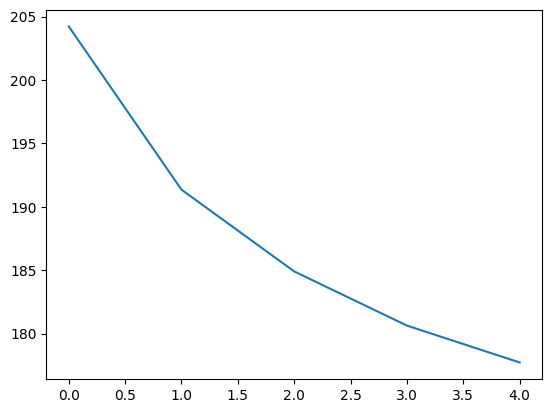

In [10]:
plt.plot(hist)
plt.show()

In [11]:
model.eval()
ground_truth = []
predictions = []
for x, y in tqdm(test_loader):
    if use_gpu:
        x = x.cuda()
    y_pred = model(x)
    y_pred = torch.argmax(y_pred, dim=1)
    ground_truth += list(y.numpy())
    if use_gpu:
        predictions += list(y_pred.cpu().detach().numpy())
    else:
        predictions += list(y_pred.detach().numpy())
print(classification_report(ground_truth, predictions))

100%|██████████| 20/20 [00:05<00:00,  3.83it/s]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1000
           1       0.78      0.71      0.74      1000
           2       0.50      0.46      0.48      1000
           3       0.48      0.43      0.45      1000
           4       0.59      0.59      0.59      1000
           5       0.52      0.62      0.56      1000
           6       0.78      0.70      0.74      1000
           7       0.71      0.71      0.71      1000
           8       0.71      0.77      0.74      1000
           9       0.68      0.75      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.64     10000
weighted avg       0.64      0.64      0.64     10000

